In [1]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from imageio.v2 import imread

torch.nn.functional.conv2d  
input = (minibatch,in_channels,iH,iW)  
weight = (out_channelsin_channels/groups,kH,kW)  

Wczytujemy obrazek i od razu nomralizujemy.

torch.Size([541, 555, 3])


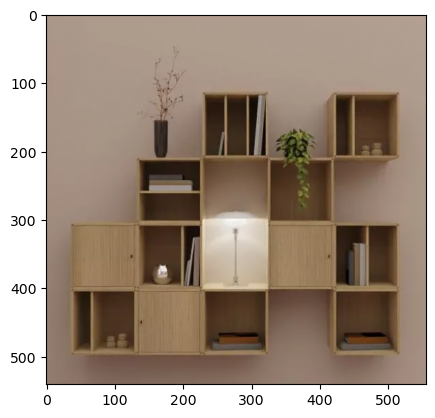

In [2]:
ori_img = torch.tensor(imread('furniture.png')/255)
print(ori_img.shape)
plt.imshow(ori_img)
plt.show()

In [3]:
def to_conv(a):
    a = torch.unsqueeze(a, dim=-1).T.float()
    return a if len(a.shape)==4 else torch.unsqueeze(a, dim=0)

def from_conv(a):
    return torch.squeeze(a).T
print(f'{to_conv(ori_img).shape} - {ori_img.shape}')
print(f'{from_conv(to_conv(ori_img)).shape} - {ori_img.shape}')

torch.Size([1, 3, 555, 541]) - torch.Size([541, 555, 3])
torch.Size([541, 555, 3]) - torch.Size([541, 555, 3])


In [4]:
wei = torch.tensor([1/3]*3).float().reshape((1,3,1,1))
wei

tensor([[[[0.3333]],

         [[0.3333]],

         [[0.3333]]]])

In [5]:
img = from_conv(F.conv2d(to_conv(ori_img), wei, padding='same', stride=1))

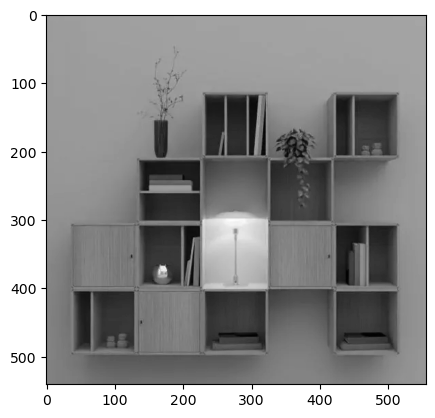

In [6]:
def print_gray(img):
    plt.imshow(img, cmap='gray')
    plt.show()
print_gray(img)

Wykorzystałem funkcję torch.nn.functional.conv2d, która wykonuje konwolucję 2d, ale dodatkowo ma podejście funkcyjne, a nie obiektowe, w przeciwieństwie do torch.nn.conv2d.  
Upewniłem się, że będziemy mieć padding, który nie zmieni nam rozmiaru obrazu wyjściowego, oraz stride wynosi 1.  
Aby móc załadować obraz i filtr do funkcji conv2d, musiałem je odpowiednio przerobić - dodać odpowiednie wymiary oraz transponować macierze, żeby wymiary się zgadzały (szerokość i wysokość obrazu mogą być stosowane zamiennie, byle zawsze tak samo).  
Na sam koniec musiałem usunąć zbędne wymiary z macierzy wynikowej oraz transponować, aby przywrócić obraz do poprzedniej orientacji.

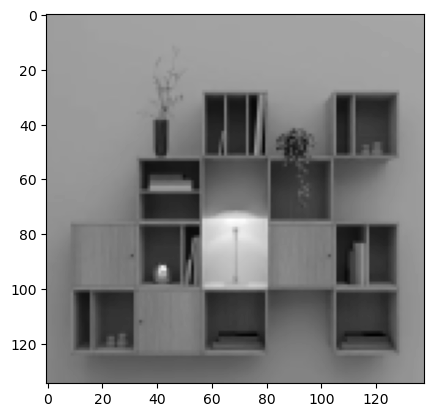

torch.Size([135, 138])

In [7]:
img1 = torch.clone(img)
wei = torch.tensor([1/16]*16).float().reshape((1,1,4,4))
img1 = from_conv(F.conv2d(to_conv(img1), wei, padding='valid', stride=4))
print_gray(img1)
img1.shape

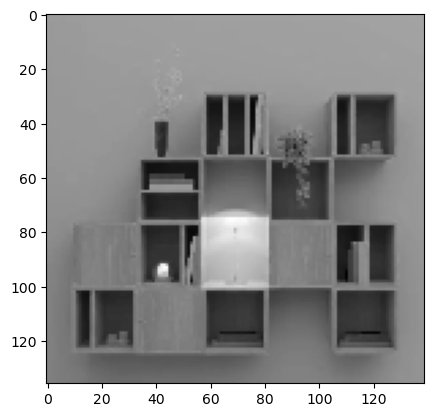

torch.Size([136, 139])

In [8]:
img2 = torch.clone(img)
img2 = from_conv(F.max_pool2d(to_conv(img2), (4,4), padding=(2,2)))
print_gray(img2)
img2.shape

Pooling wykonany przy pomocy konwolucji, biorący jako wartość średnią oraz pooling wykonany przy pomocy funkcji torch.nn.functional.max_pool2d(przyjmuje bardzo podobne argumenty do konwolucji). Dodatkowo przy pierwszej metodzie nie użyłem paddingu, więc obraz jest trochę mniejszy, niż przy drugiej gdzie użyłem paddingu będącego połową filtru.  
Wybieram opcję drugą - czyli poolingu wykorzystującego max.
Bardziej podoba mi się obraz, oraz krawędzi wydają się być mocniejsze, co liczę, że poprawi wyniki.

In [9]:
img = img2

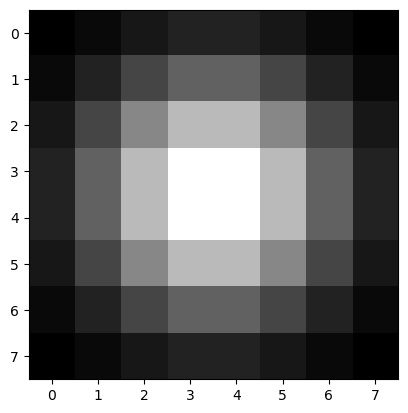

In [10]:
def prep_gauss(n, std=torch.tensor(1.8)):
    ax = torch.linspace(-(n-1)/2, (n-1)/2, n)
    gauss = torch.exp(-0.5*torch.square(ax)/torch.square(std))
    kernel = torch.outer(gauss, gauss)
    return kernel/torch.sum(kernel)

print_gray(prep_gauss(8))

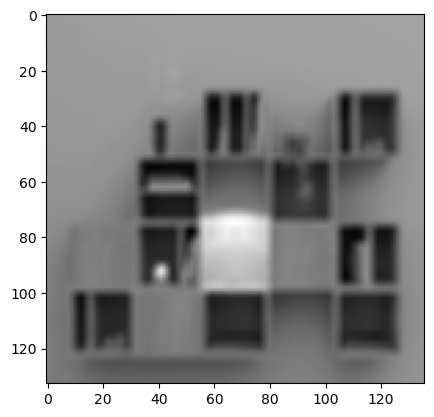

torch.Size([133, 136])

In [11]:
def try_gauss(img, n, std=torch.tensor(1.8)):
    gauss = prep_gauss(n, std)
    new_img = from_conv(F.conv2d(to_conv(img), to_conv(gauss), padding='valid', stride=1))
    print_gray(new_img)
    return new_img

img = try_gauss(img, 4)
img.shape

Wybieram rozmiar 4, ponieważ wydaje mi sie, że traci on najmniej względem oryginału, ale równocześnie pozbywa się różnych zbędnych artefaktów.  
Korzystam głównie z funkcji matematycznych do wyliczenia filtru gaussa, który wykorzystuję do rozmycia obrazu.


In [12]:
grad1 = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]])
grad2 = grad1.T
grad1 = torch.unsqueeze(grad1, dim=-1).T.float()
grad2 = torch.unsqueeze(grad2, dim=-1).T.float()
grad = torch.stack((grad1,grad2), dim=0)
print(grad.shape)
grad

torch.Size([2, 1, 3, 3])


tensor([[[[ 1.,  0., -1.],
          [ 2.,  0., -2.],
          [ 1.,  0., -1.]]],


        [[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])

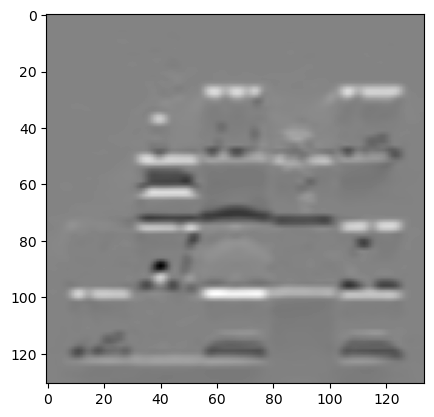

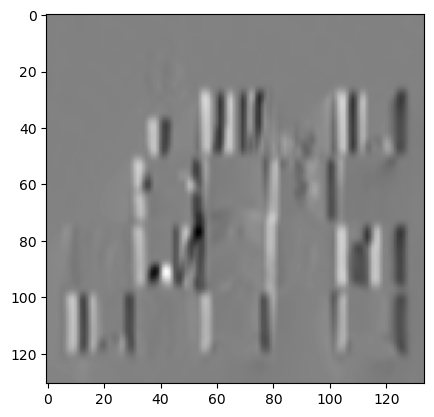

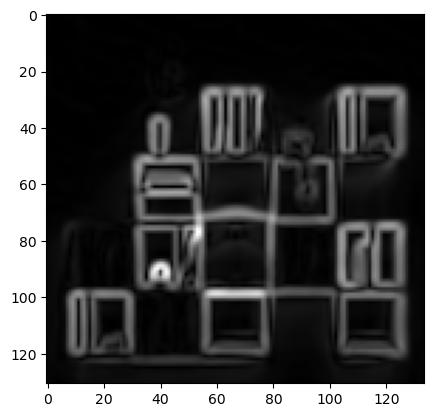

In [13]:
sobol_img = from_conv(F.conv2d(to_conv(img), grad, stride=1, padding='valid'))
print_gray(sobol_img[:,:,0])
print_gray(sobol_img[:,:,1])
sobol_img = torch.sqrt(torch.square(sobol_img[:,:,0]) + torch.square(sobol_img[:,:,1]))
print_gray(sobol_img)

Użyłem filtra o 2 kanałach wyjściowych, na każdą składową gradientu, więc otrzymałem 1 tensor z oboma gradientami.  
Aby uzyskać obrazek o tylko jednym kanale, podniosłem tensor do kwadratu i dodałem oba kanały.  

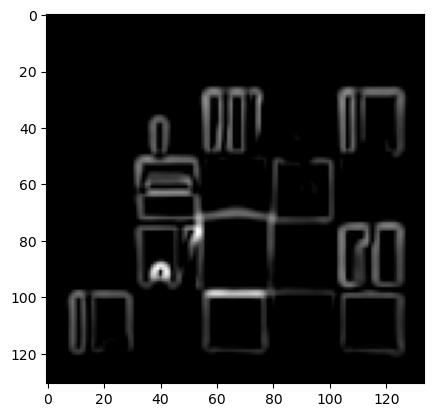

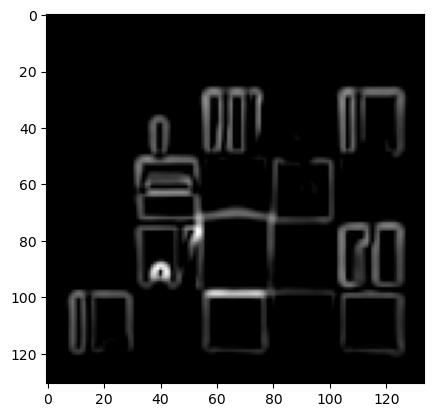

tensor(False)

In [14]:
def try_relu(img, val, draw=True):
    new_img = F.relu(img-val)
    if draw:
        print_gray(new_img)
    return new_img

sobol_img=try_relu(sobol_img, 1/3)
sobol_img=sobol_img/sobol_img.max()
print_gray(sobol_img)
(sobol_img>1).any() or (sobol_img<0).any()

In [15]:
img=sobol_img#[2:-2,2:-2]

Można użyć funkcji konwolucji, z wielowymiarowym filtrem, gdzie każdy kanał filtru odpowiada za inny rozmiar kwadratu.  
Zdecydowałem jednak, że nie wiem jak zoptymalizowane są mnożenia macierzy, a potencjalnie w takiej sytuacji moglibyśmy wykonywać mnóstwo pustych mnożeń razo 0, zużywających jedynie moc obliczeniową. (np. podczas liczenia kwadratu 3x3, ale mając filtr rozmiaru 100x100)  
Dlatego będę liczył iteracyjnie, z filtrami o tylko jednym kanale.

In [16]:
def sq(n):
    sq = torch.ones((n,n))
    sq[1:-1,1:-1] = 0
    return sq

sq(10)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

16


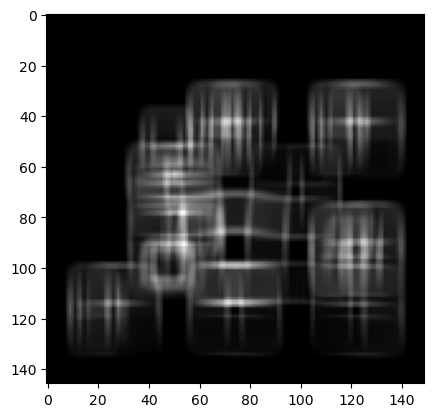

17


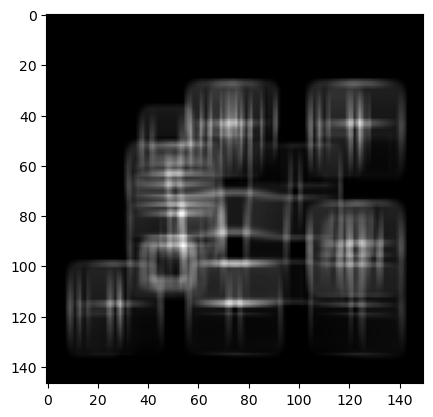

18


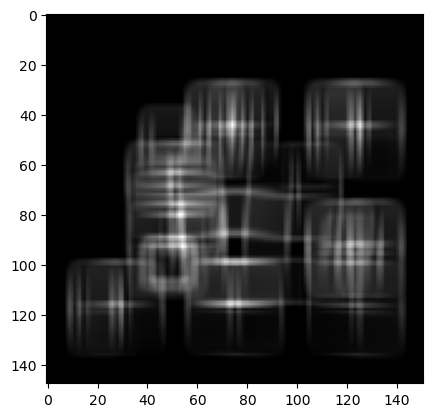

19


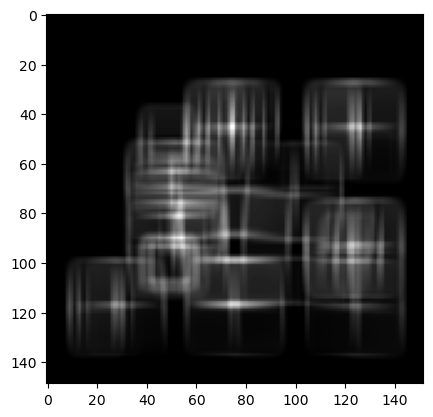

20


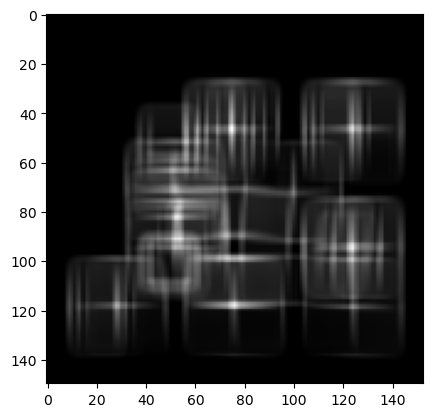

21


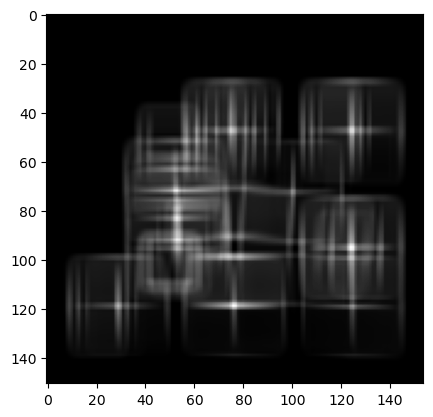

22


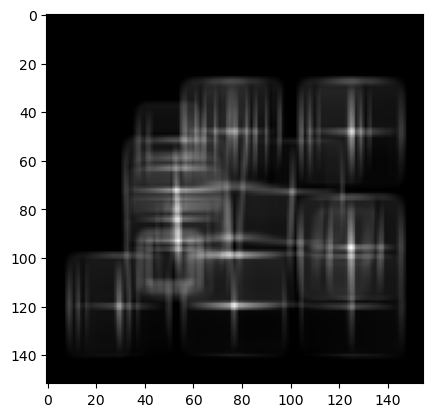

23


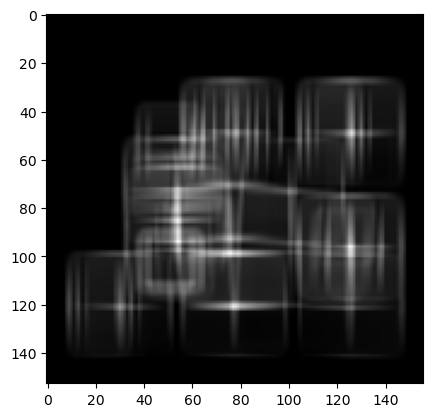

24


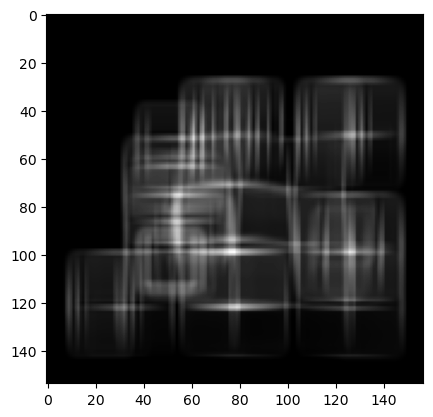

25


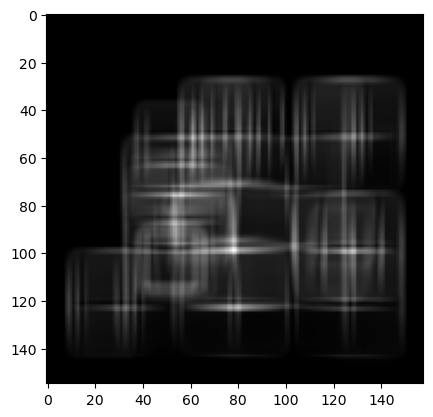

26


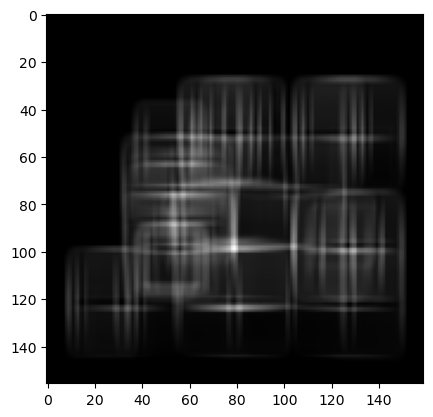

27


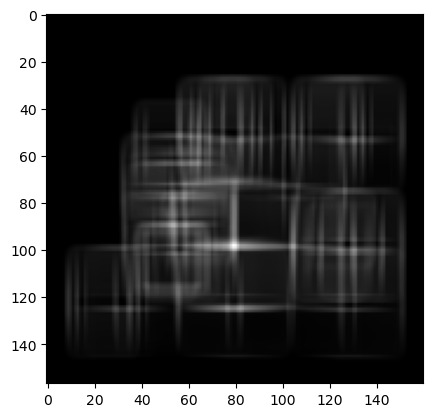

28


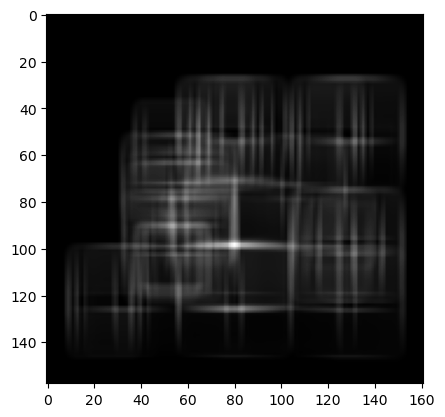

29


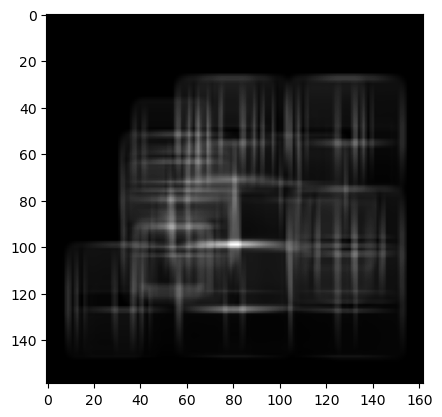

30


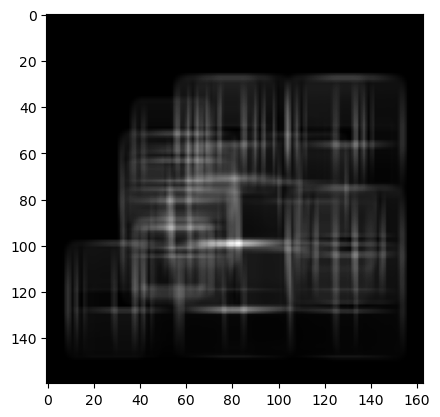

31


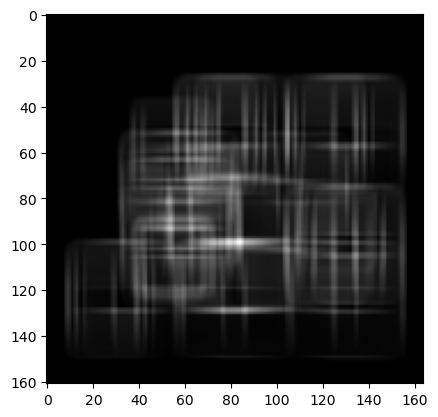

In [17]:
def try_hough(img, n):
    wei = to_conv(sq(n))
    res = from_conv(F.conv_transpose2d(to_conv(img), wei, stride=1, output_padding=(0,0)))
    print_gray(res)
    return res

imgs = []
for i in range(16,32):
    print(i)
    imgs = imgs + [try_hough(img,i)]
    

Przestrzenie głosowania wyglądają dosyć ciekawie, powinniśmy je jeszcze przepuścić przez relu.  
Dla każdego kwadratu. otrzymujemy zasadniczo krzyż z najjaśniejszym punktem w środku.  
Dzieje się tak ponieważ w środku potencjalnie łapiemy wszystkie punkty na obwodzie, a przesuwając się pionowo lub poziomo, wciąż dostajemy głosy od 2 równoległych krawędzi, ale tracimy głosy od 2 pozostałych krawędzi (również równoległych, ale prostopdałych do przemieszczenia).  
Do liczenia głosów wykorzystałem conv2d_transpose, które działa bardzo podobnie do conv2d, ale dodatkowo dokonuje transpozycji macierzy wejściowej.

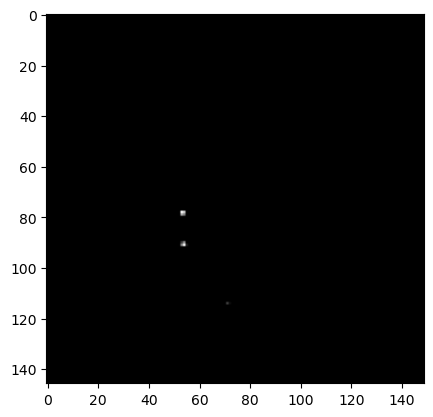

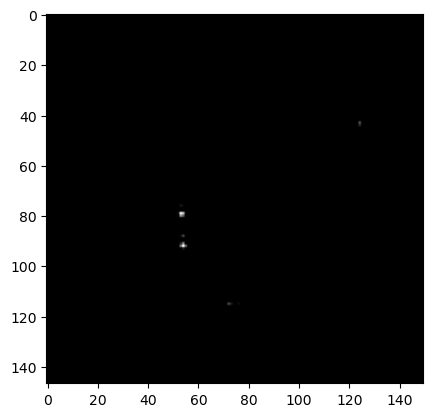

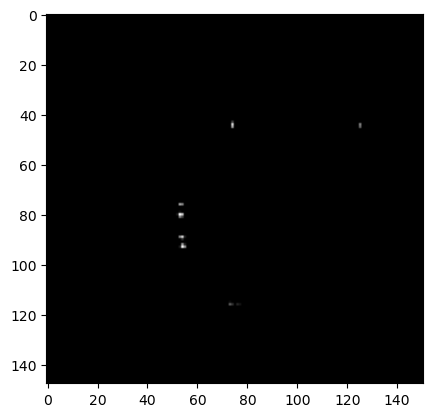

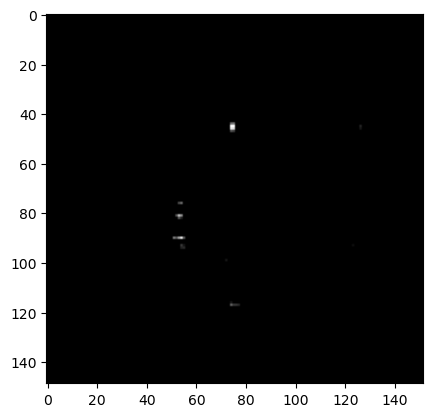

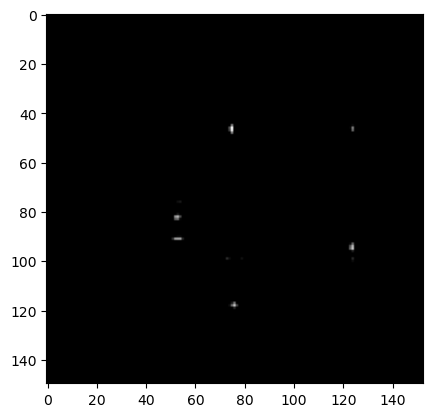

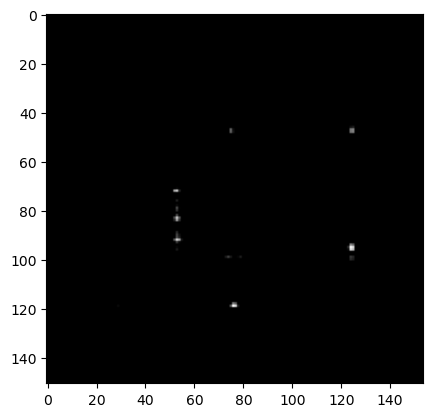

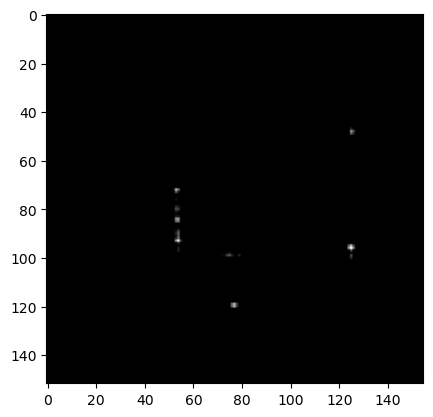

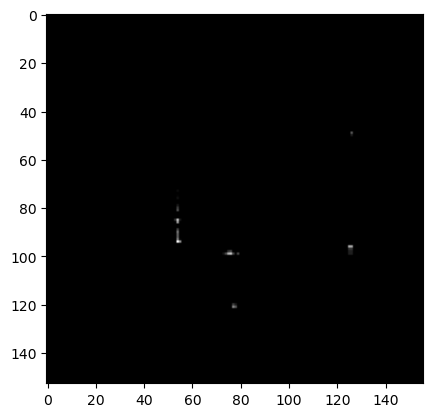

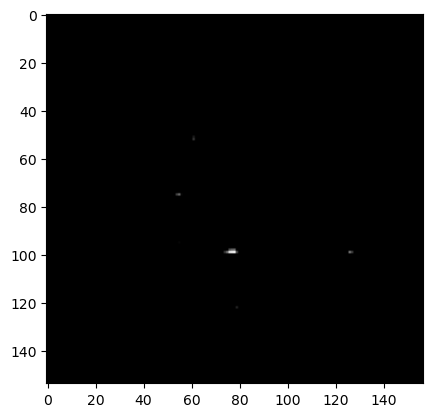

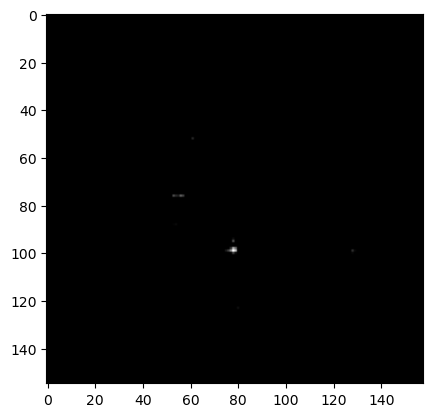

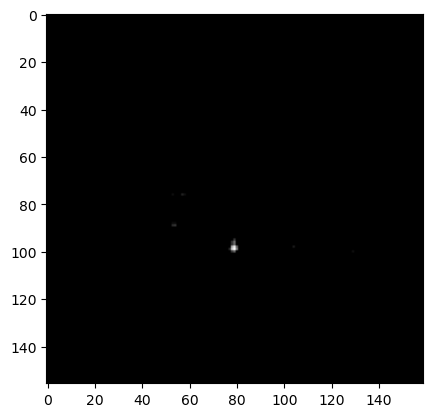

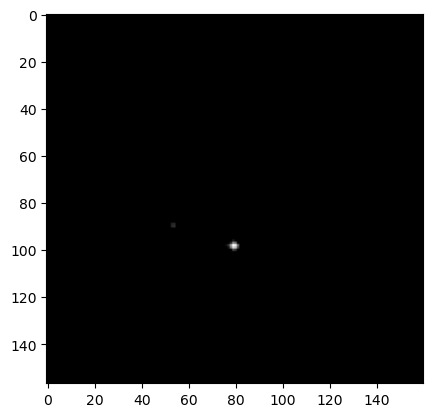

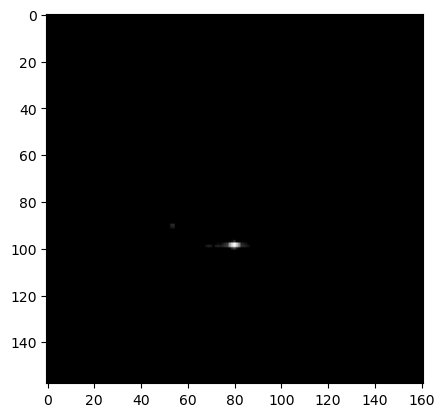

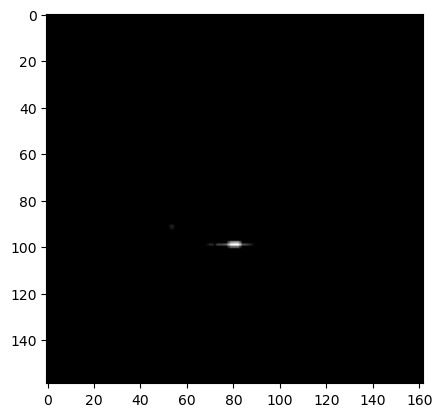

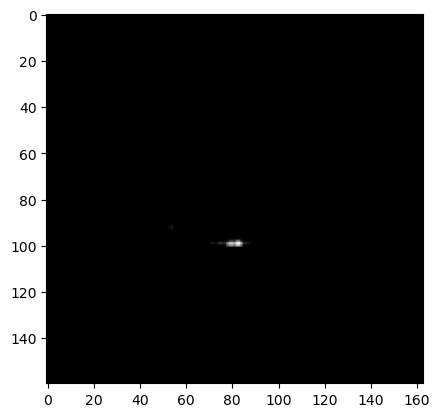

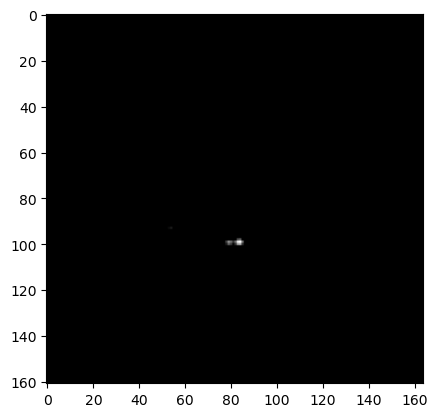

In [18]:
for ix, img in enumerate(imgs):
    imgs[ix]=try_relu(img, 2*ix/3+16)

16


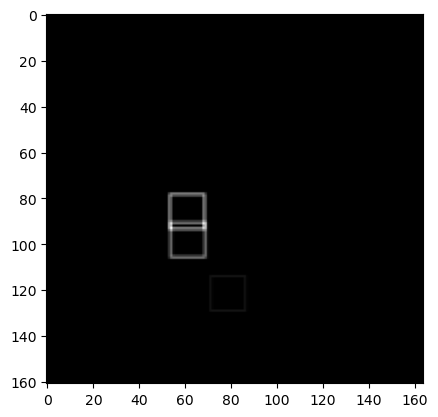

17


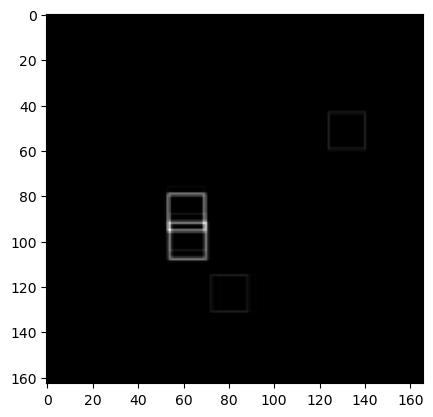

18


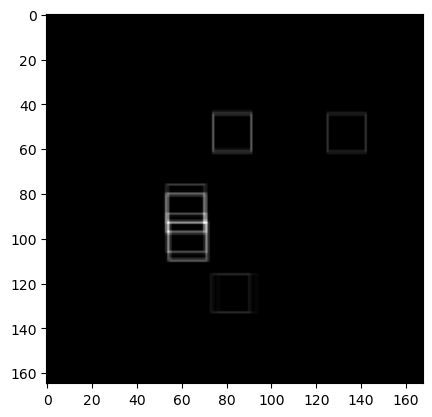

19


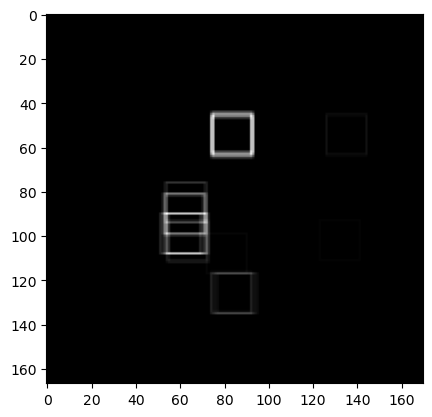

20


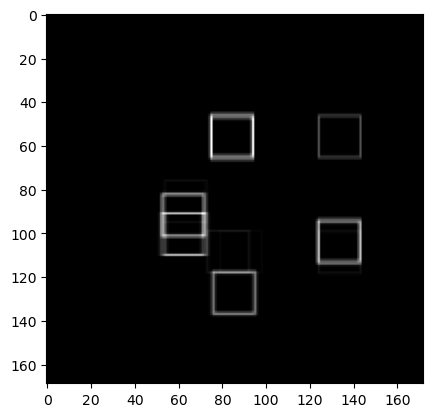

21


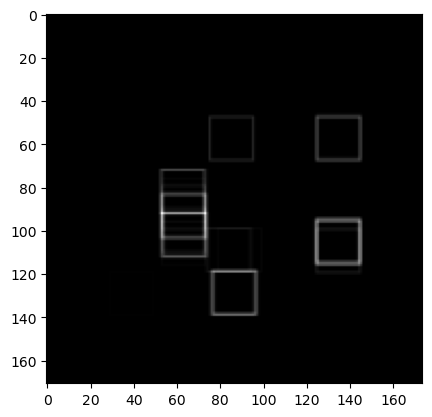

22


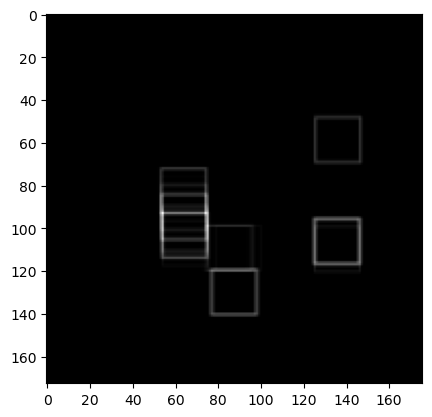

23


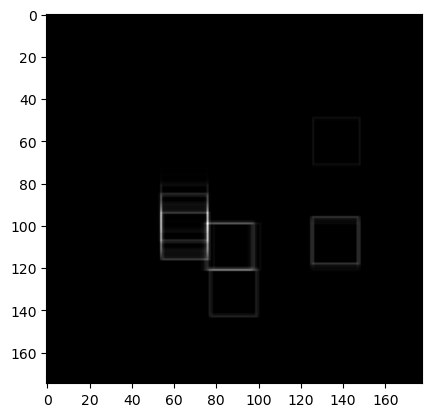

24


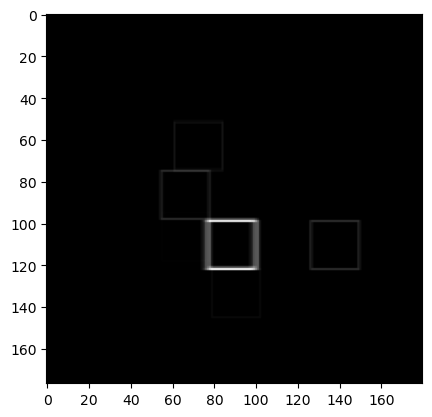

25


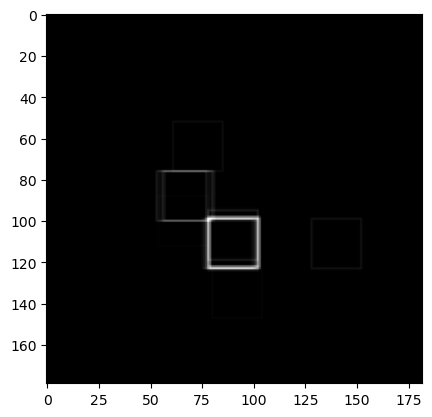

26


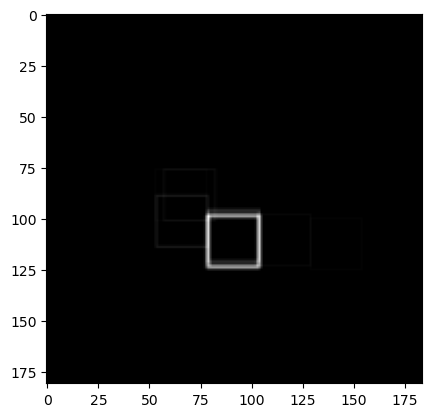

27


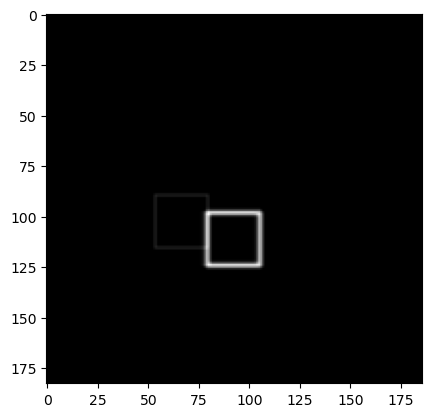

28


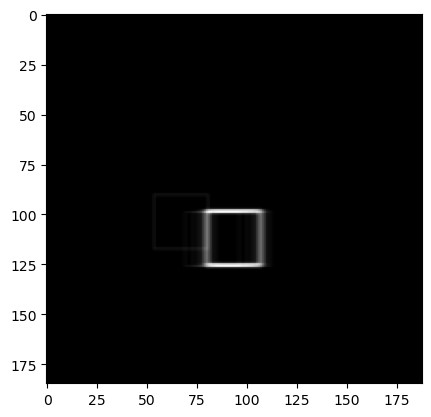

29


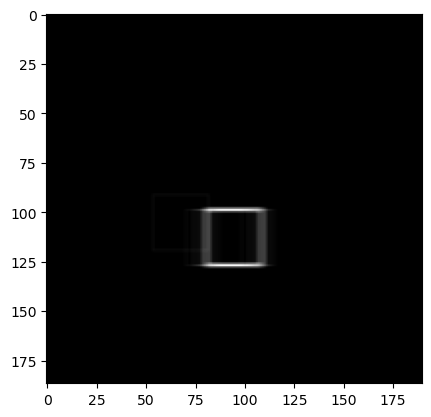

30


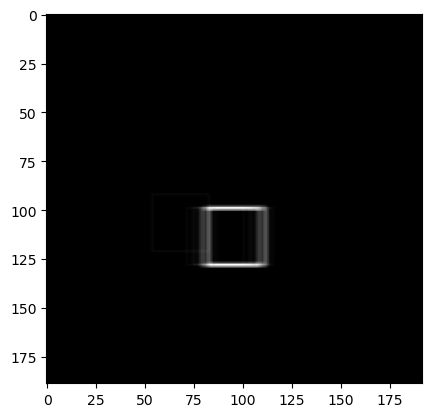

31


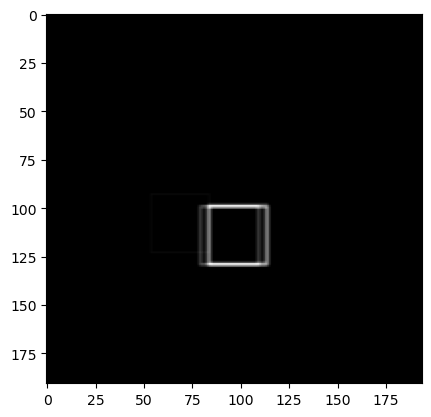

In [19]:
res = torch.zeros(img.shape)
for ix, imgx in enumerate(imgs):
    print(ix+16)
    tmp=try_hough(imgx, ix+16)[0:img.shape[0],0:img.shape[1]]
    res+=(tmp/tmp.max())#*(16-ix+2))

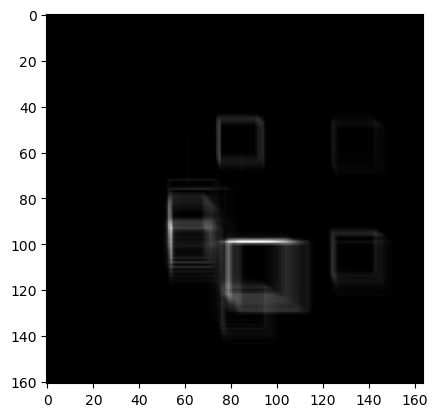

In [20]:
print_gray(res)

In [21]:
row_f = ori_img.shape[0]//res.shape[0]
col_f = ori_img.shape[1]//res.shape[1]


In [22]:
upscaled_sq = torch.squeeze(F.interpolate(torch.unsqueeze(torch.unsqueeze(res,dim=0), dim=0), size=ori_img[:,:,0].shape))

In [23]:
img_with_sq = ori_img
img_with_sq[:,:,0] += upscaled_sq


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


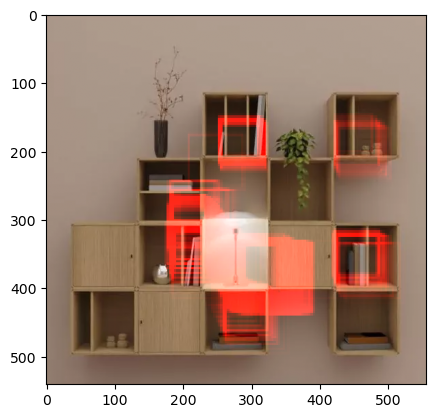

In [24]:
plt.imshow(img_with_sq)
plt.show()

Niestety wynik nie jest wybitny, ale moim zdaniem ma trochę sensu - kwadraty znajdują się mniej więcej w dobrych miejscach.  
Niestety nie mam wytarczająco czasu, ani na ten moment pomysłu jak poprawić moją implementację, ale wydaje mi się, że największe problemy wynikają z:  
- Upscaling - szczególnie że przy róznych konwolucjach - szczególnie transponowanych, obraz zwiększał rozmiar a nie powinien (nie umiałem temu zapobiec...), przez co kwadraty zostały powiększone mniej niż powinny
- downscaling - później przy upscalingu wynikają problemy, dodatkowo wybrałem pooling max, co sprawiało, że krawędzie były grubsze i intensywniejsze niż powinny, przez co wiele kwadratów jest bardzo rozmazanych
- conv_transpose2d - niestety nie wiem jak zapobiec rośnieciu obrazka, może powinienem samemu na koniec obcinać obrazek do odpowiedniego rozmiaru.
- Nie dokończylismy wykrywania krawędzi
- Ciężko jest dobrać sensowne wartości przy filtrowaniu dobrych kwadratów, aby nie usunąć za dużo oraz nie mieć za dużych zakłóceń
- Do tego wszystkiego, sam obrazek jest dosyć trudny
Moim zdaniem z tych powodów miejsca gdzie kwadraty się znadują nie zgaddzają się bardzo dokłądnie oraz rozmiary kwadratów pozostawiają trochę do życzenia.

Poniżej powtarzam wszystko dla nowego obrazka.


torch.Size([810, 810])


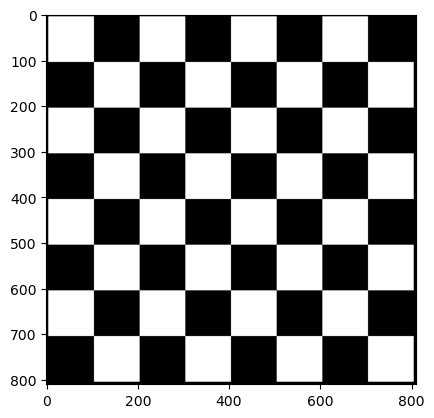

In [25]:
ori_img = torch.tensor(imread('Chess_Board.png')/255)
print(ori_img.shape)
print_gray(ori_img)

In [26]:
print(f'{to_conv(ori_img).shape} - {ori_img.shape}')
print(f'{from_conv(to_conv(ori_img)).shape} - {ori_img.shape}')

torch.Size([1, 1, 810, 810]) - torch.Size([810, 810])
torch.Size([810, 810]) - torch.Size([810, 810])


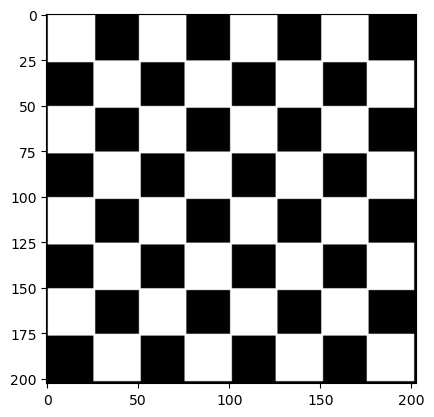

torch.Size([203, 203])

In [27]:
img2 = torch.clone(ori_img)
img2 = from_conv(F.max_pool2d(to_conv(img2), (4,4), padding=(2,2)))
print_gray(img2)
img2.shape

Pooling wykonany przy pomocy konwolucji, biorący jako wartość średnią oraz pooling wykonany przy pomocy funkcji torch.nn.functional.max_pool2d(przyjmuje bardzo podobne argumenty do konwolucji). Dodatkowo przy pierwszej metodzie nie użyłem paddingu, więc obraz jest trochę mniejszy, niż przy drugiej gdzie użyłem paddingu będącego połową filtru.  
Wybieram opcję drugą - czyli poolingu wykorzystującego max.
Bardziej podoba mi się obraz, oraz krawędzi wydają się być mocniejsze, co liczę, że poprawi wyniki.

In [28]:
img = img2

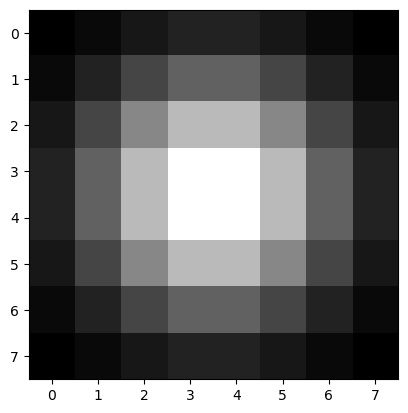

In [29]:

print_gray(prep_gauss(8))

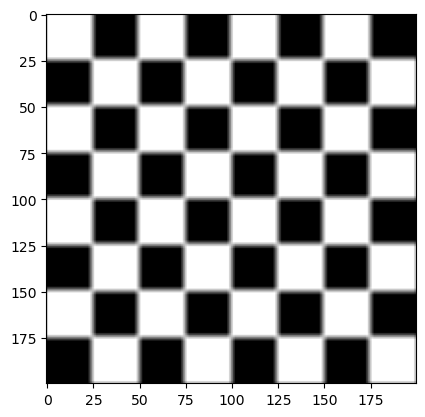

torch.Size([200, 200])

In [30]:

img = try_gauss(img, 4)
img.shape

In [31]:
grad1 = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]])
grad2 = grad1.T
grad1 = torch.unsqueeze(grad1, dim=-1).T.float()
grad2 = torch.unsqueeze(grad2, dim=-1).T.float()
grad = torch.stack((grad1,grad2), dim=0)
print(grad.shape)
grad

torch.Size([2, 1, 3, 3])


tensor([[[[ 1.,  0., -1.],
          [ 2.,  0., -2.],
          [ 1.,  0., -1.]]],


        [[[ 1.,  2.,  1.],
          [ 0.,  0.,  0.],
          [-1., -2., -1.]]]])

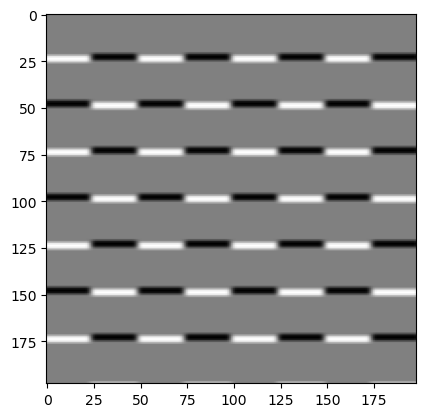

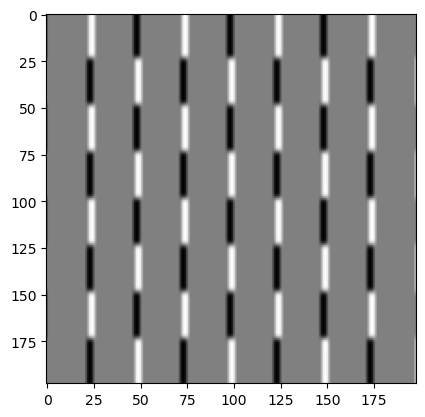

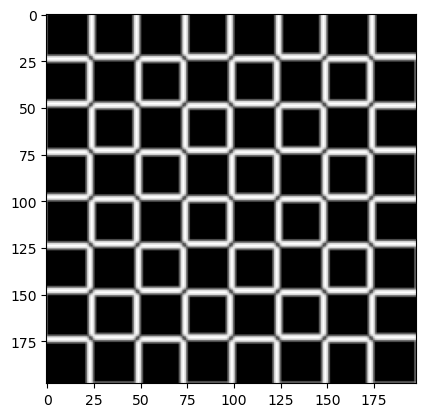

In [32]:
sobol_img = from_conv(F.conv2d(to_conv(img), grad, stride=1, padding='valid'))
print_gray(sobol_img[:,:,0])
print_gray(sobol_img[:,:,1])
sobol_img = torch.sqrt(torch.square(sobol_img[:,:,0]) + torch.square(sobol_img[:,:,1]))
print_gray(sobol_img)

Użyłem filtra o 2 kanałach wyjściowych, na każdą składową gradientu, więc otrzymałem 1 tensor z oboma gradientami.  
Aby uzyskać obrazek o tylko jednym kanale, podniosłem tensor do kwadratu i dodałem oba kanały.  

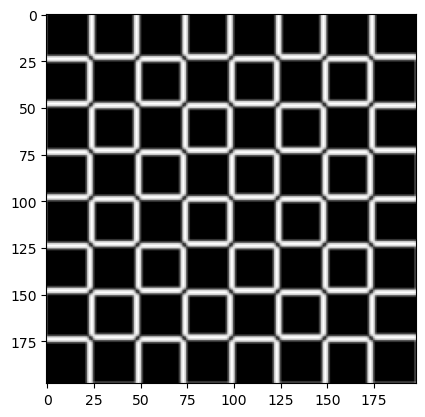

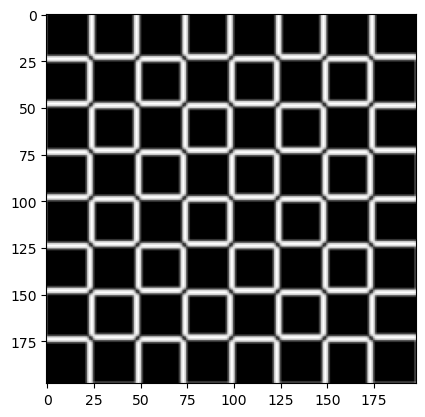

tensor(False)

In [33]:
def try_relu(img, val, draw=True):
    new_img = F.relu(img-val)
    if draw:
        print_gray(new_img)
    return new_img

sobol_img=try_relu(sobol_img, 1/3)
sobol_img=sobol_img/sobol_img.max()
print_gray(sobol_img)
(sobol_img>1).any() or (sobol_img<0).any()

In [34]:
img=sobol_img#[2:-2,2:-2]

Można użyć funkcji konwolucji, z wielowymiarowym filtrem, gdzie każdy kanał filtru odpowiada za inny rozmiar kwadratu.  
Zdecydowałem jednak, że nie wiem jak zoptymalizowane są mnożenia macierzy, a potencjalnie w takiej sytuacji moglibyśmy wykonywać mnóstwo pustych mnożeń razo 0, zużywających jedynie moc obliczeniową. (np. podczas liczenia kwadratu 3x3, ale mając filtr rozmiaru 100x100)  
Dlatego będę liczył iteracyjnie, z filtrami o tylko jednym kanale.

In [35]:
sq(10)

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

16


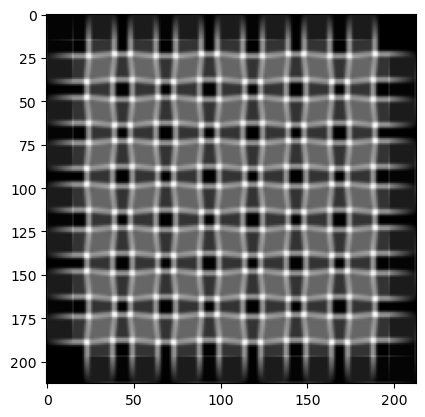

17


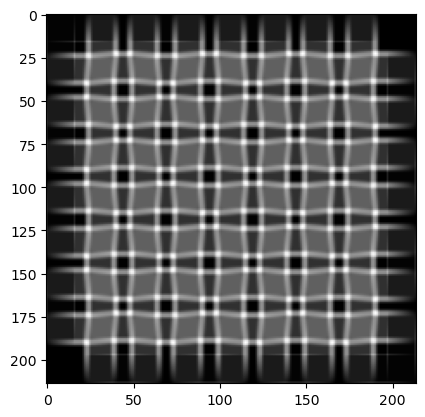

18


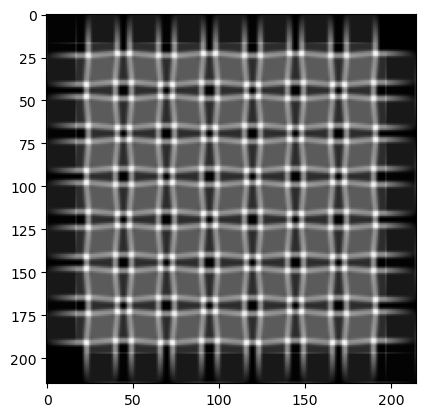

19


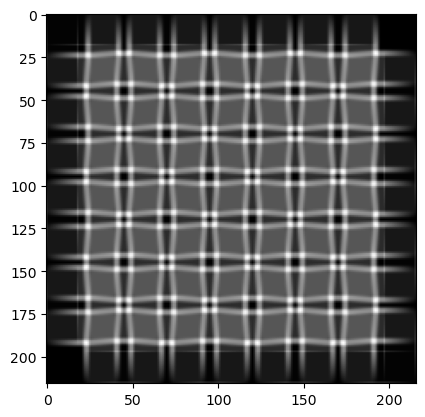

20


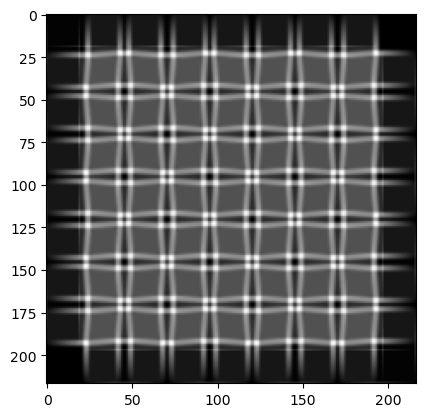

21


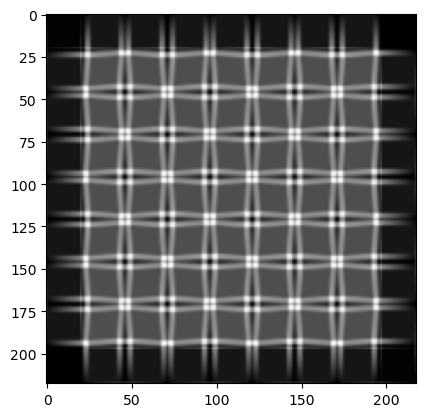

22


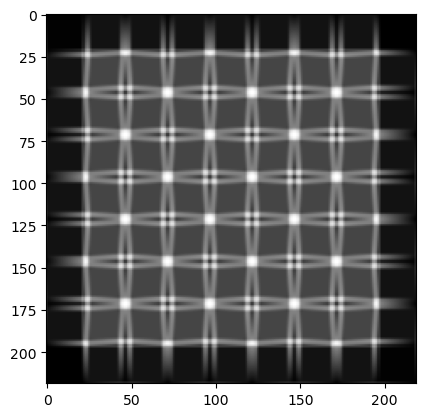

23


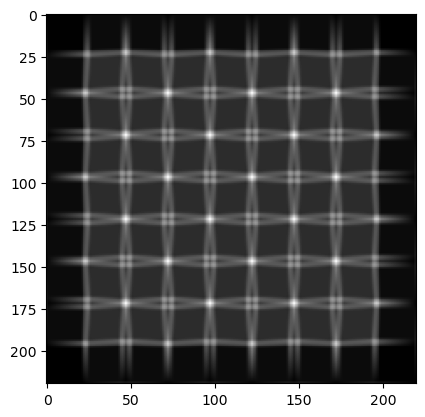

24


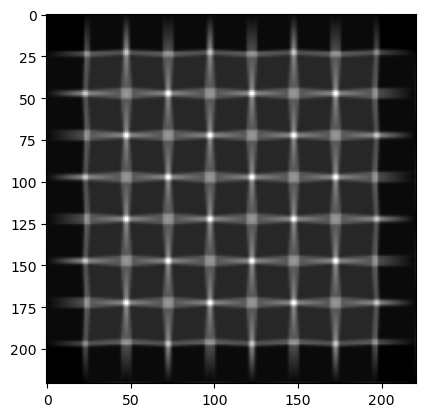

25


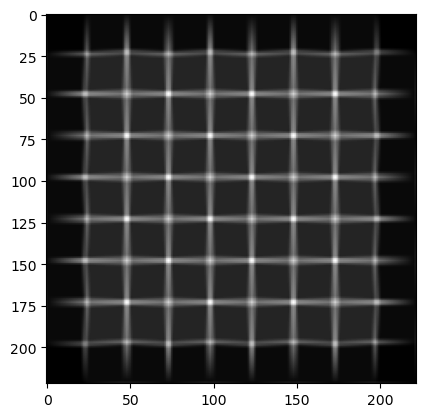

26


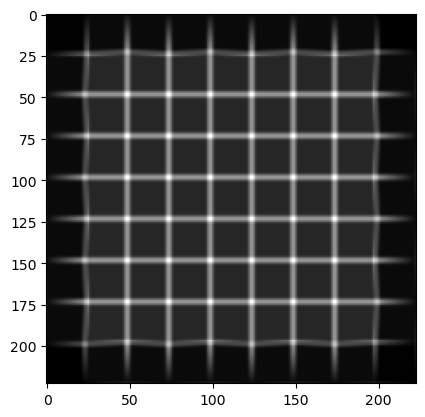

27


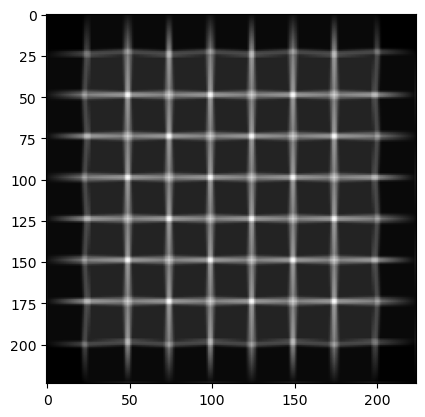

28


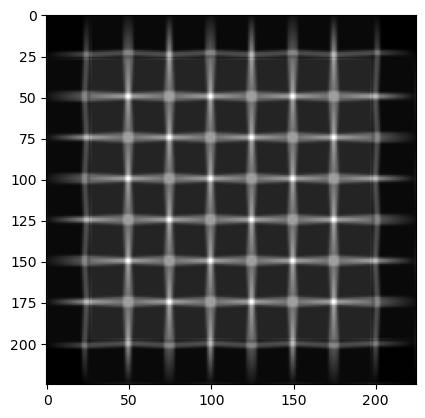

29


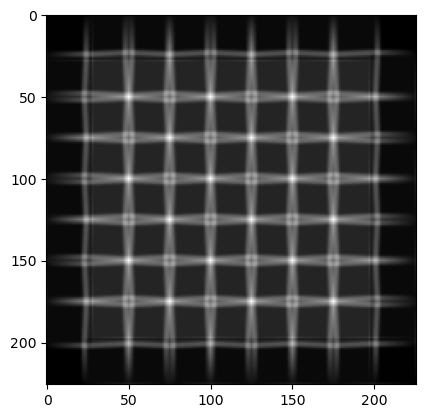

30


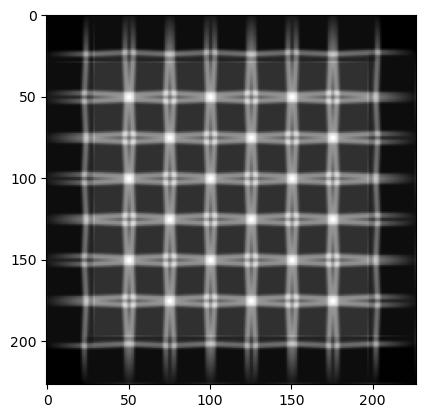

31


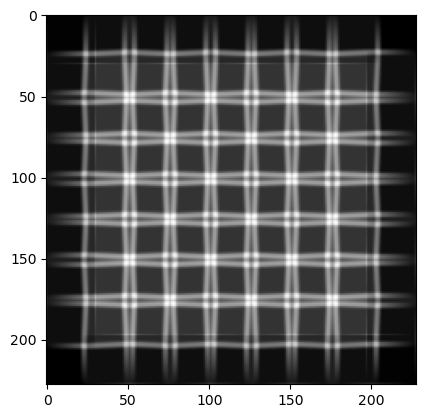

In [36]:

imgs = []
for i in range(16,32):
    print(i)
    imgs = imgs + [try_hough(img,i)]
    

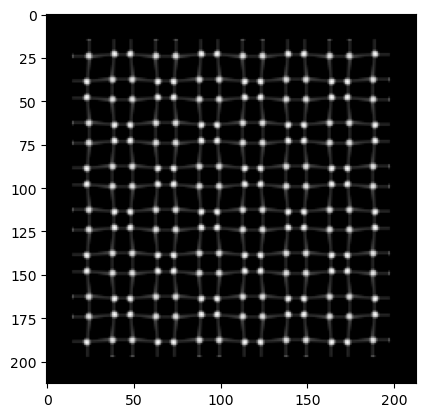

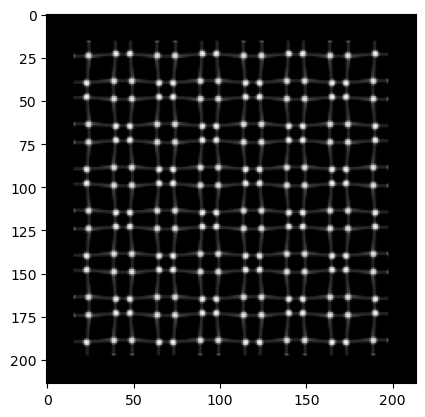

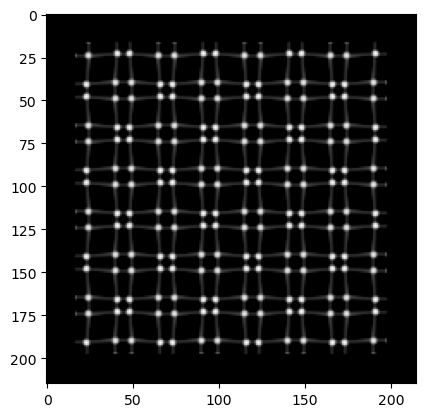

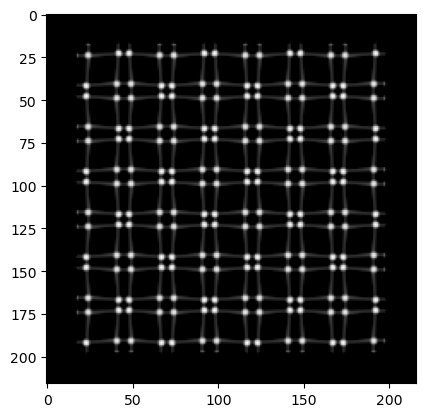

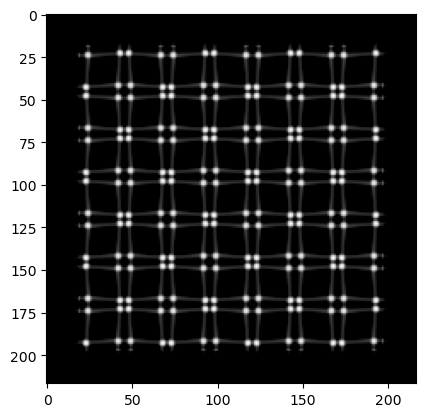

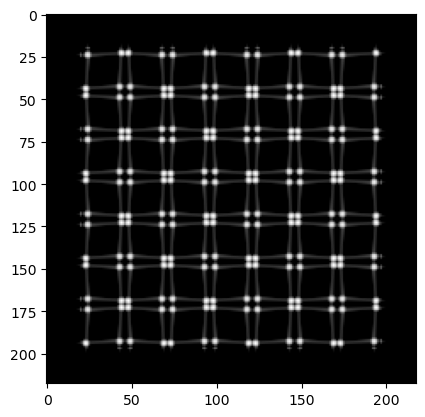

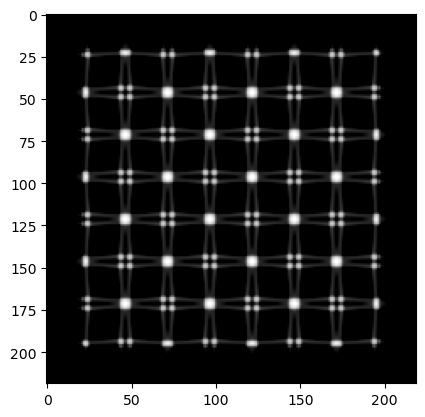

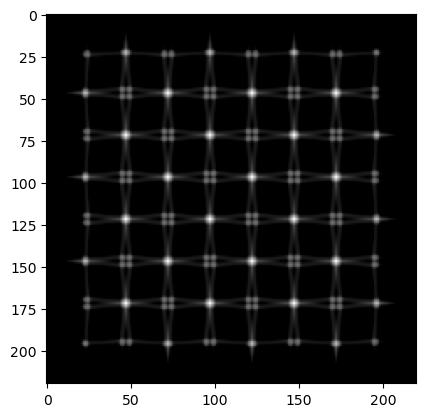

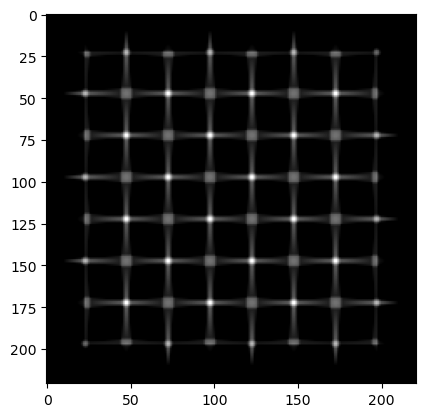

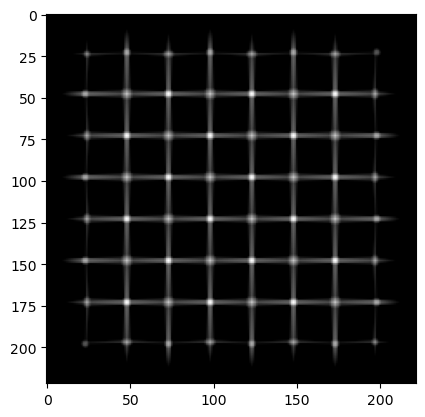

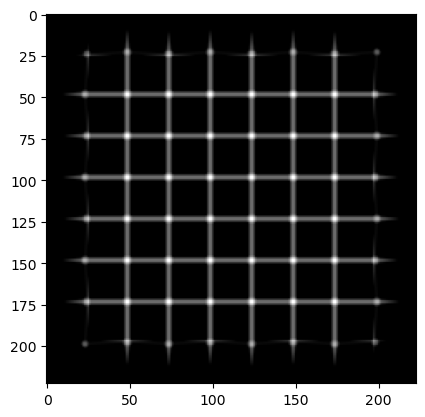

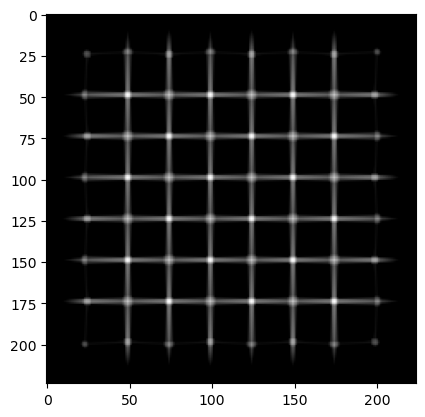

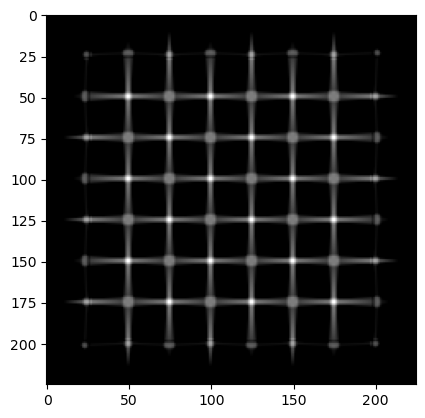

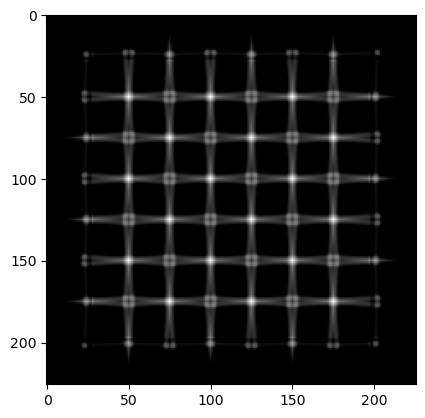

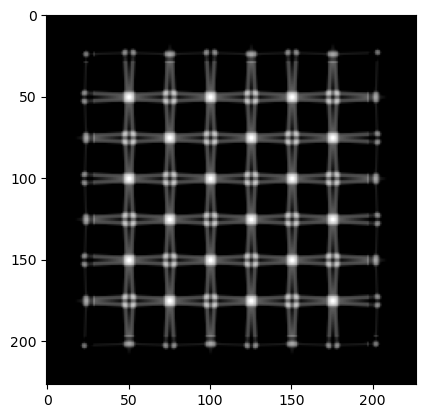

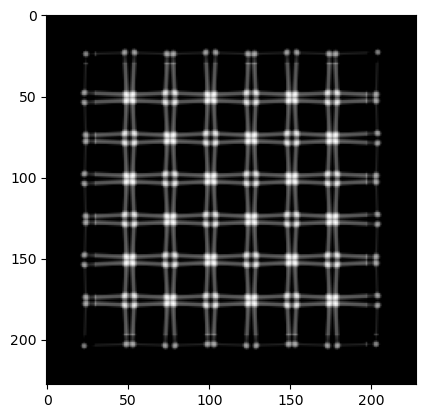

In [37]:
for ix, img in enumerate(imgs):
    imgs[ix]=try_relu(img, 2*ix/3+16)

16


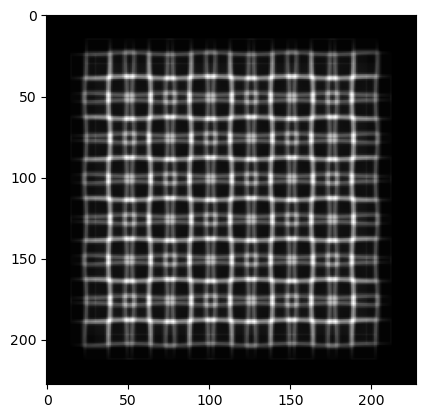

17


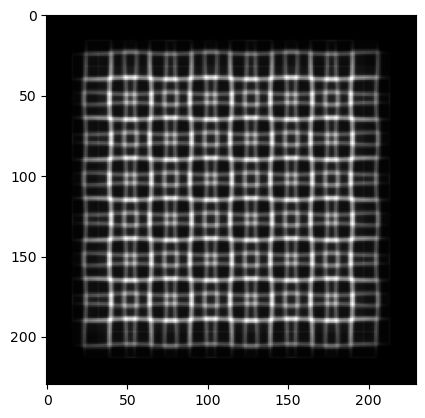

18


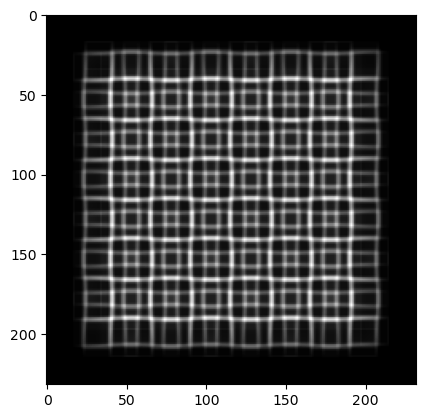

19


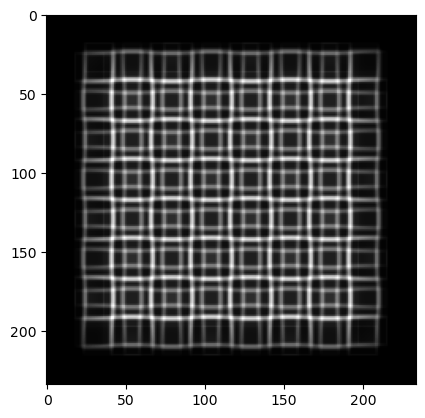

20


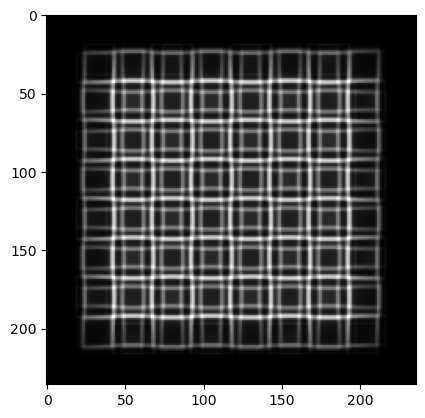

21


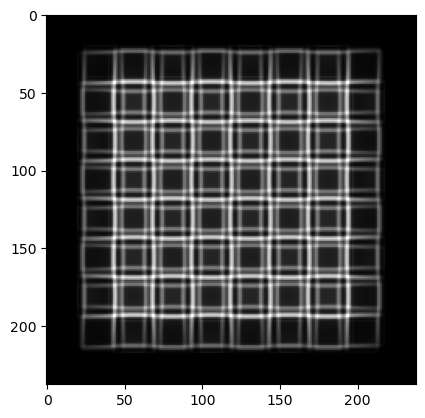

22


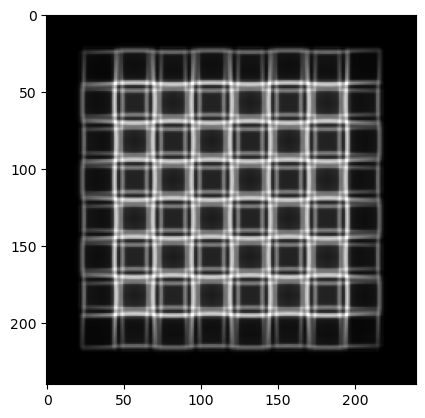

23


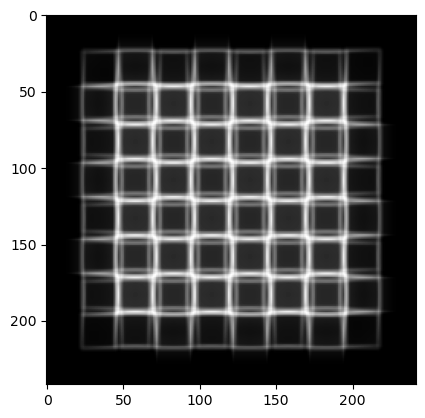

24


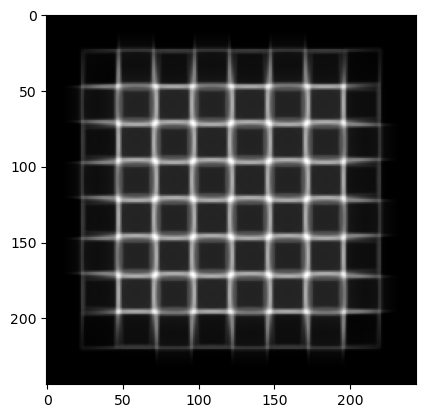

25


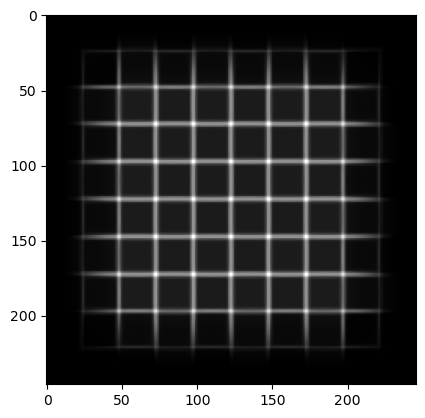

26


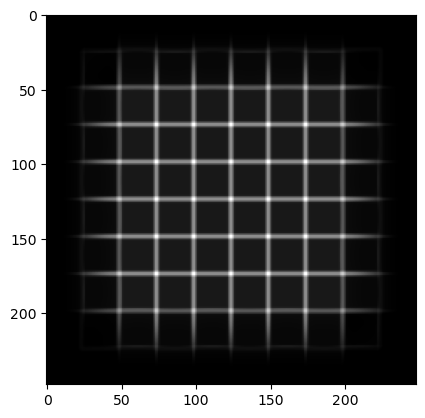

27


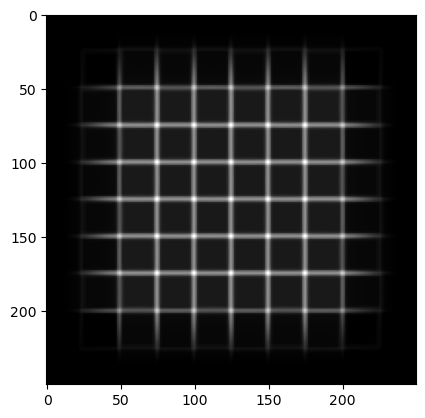

28


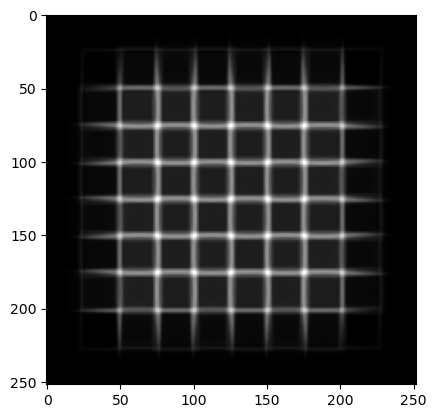

29


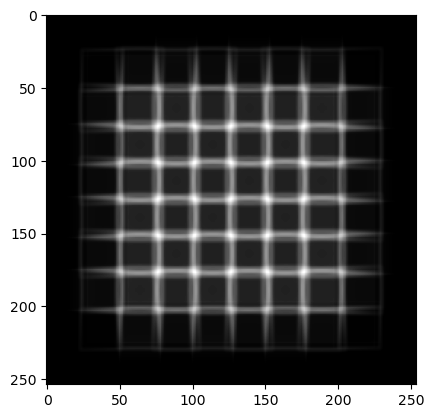

30


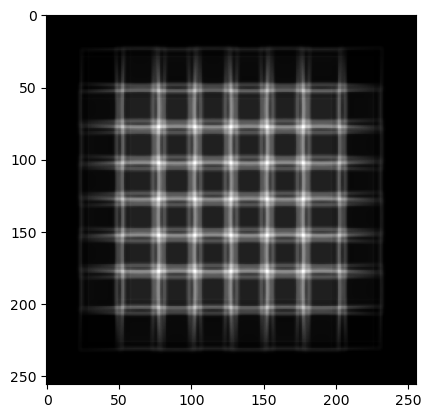

31


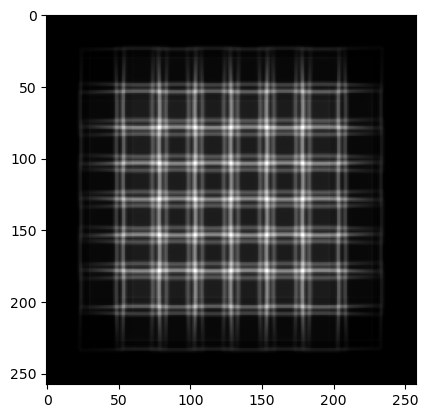

In [38]:
res = torch.zeros(img.shape)
for ix, imgx in enumerate(imgs):
    print(ix+16)
    tmp=try_hough(imgx, ix+16)[0:img.shape[0],0:img.shape[1]]
    res+=(tmp/tmp.max())#*(16-ix+2))

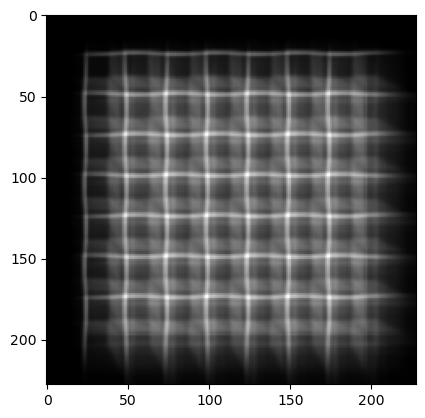

In [39]:
print_gray(res)

In [40]:
row_f = ori_img.shape[0]//res.shape[0] + 1
col_f = ori_img.shape[1]//res.shape[1] + 1


In [41]:
upscaled_sq = torch.squeeze(F.interpolate(torch.unsqueeze(torch.unsqueeze(res,dim=0), dim=0), size=ori_img.shape))

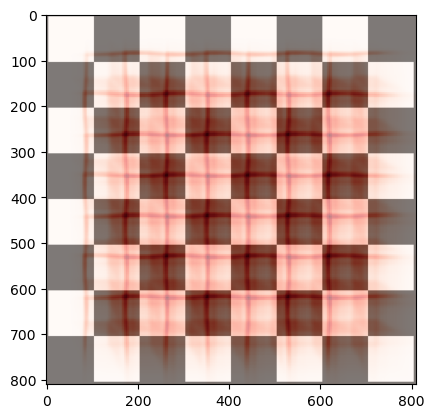

In [42]:
plt.imshow(ori_img, cmap='gray')
plt.imshow(upscaled_sq, cmap='Reds', alpha=0.5)
plt.show()

Moim zdaniem jest to wynik zadawalający, trochę się psuje przez krawędzie (najbardziej zewnętrzne kwadraty mają za mało głosów by być brane pod uwagę).  
Dodatkowo rozmiary trochę się psują przez przeskalowania, ale ogólnie wydaje się być dobrze, moim zdaniem.
Dodatkowo ja liczę teraz różne rozmiary, a mógłbym wziąc np. tylko 26, co dałoby dużo lepszy wynik.